In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

In [2]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = 1, it's a 'cat' picture.


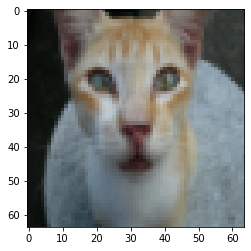

In [3]:
index =11
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[0, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")


**Exercise:** Find the values for:
    - m_train (number of training examples)
    - m_test (number of test examples)
    - num_px (= height = width of a training image)
Remember that `train_set_x_orig` is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access `m_train` by writing `train_set_x_orig.shape[0]`.


In [76]:
print(train_set_x_orig.shape[0])
print(test_set_x_orig.shape[0])
print(test_set_x_orig.shape[1])
print(test_set_x_orig.shape[2])
print(test_set_x_orig.shape[3])

209
50
64
64
3


**Exercise:** Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num\_px $*$ num\_px $*$ 3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [5]:
train_set_x_flatten= train_set_x_orig.reshape(train_set_x_orig.shape[1]*train_set_x_orig.shape[2]*train_set_x_orig.shape[3],train_set_x_orig.shape[0])
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[1]*test_set_x_orig.shape[2]*test_set_x_orig.shape[3],test_set_x_orig.shape[0])

In [6]:
#Normalize Data
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

In [7]:
def sigmoid(x):
    return 1/(1+ np.exp(-x))

In [8]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


In [9]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """

    w = np.zeros((dim,1))
    b = 0
    return w,b

In [10]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


### 4.3 - Forward and Backward propagation

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

**Exercise:** Implement a function `propagate()` that computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [11]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    m = X.shape[1]
     ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T,X) + b)     # compute activation
    cost = np.sum(((- np.log(A))*Y + (np.log(1-A))*(1-Y)))  # compute cost
     ### END CODE HERE ###

    ##return -1 * cost /X.shap[1]
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (np.dot(X,(A-Y).T))/m
    db = (np.sum(A-Y))/m
    ### END CODE HERE ###

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost


In [12]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = -6.595376330205713


In [13]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    costs = []
 
    for i in range(num_iterations):
      grads, cost  =  propagate(w,b,X,Y)
      dw = grads["dw"]
      db = grads["db"]
      
      w = w-(learning_rate*dw)
      b = b-(learning_rate*db)

      # Record the costs
      costs.append(cost)
    
       # Print the cost every 100 training iterations
      if print_cost and (i+1) % 50 == 0:
         print ("Cost after iteration %i: %f" %((i+1), cost))

    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs


In [14]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = True)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

Cost after iteration 50: -5.145378
Cost after iteration 100: -2.599019
w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


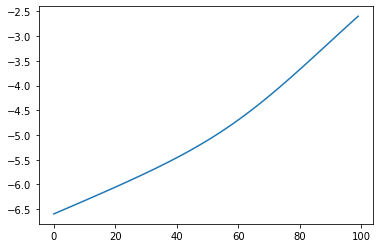

In [15]:
import matplotlib.pyplot as plt

plt.plot(costs)

## Predict
1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5)

In [16]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)


    A = sigmoid(np.dot(w.T,X) + b)
    for i in range(A.shape[1]):
        ## Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0,i] >= 0.5):
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0

    return Y_prediction
        


In [17]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


In [18]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [19]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = False)

train accuracy: 91.38755980861244 %
test accuracy: 34.0 %


*************test_set_x_flatten************
(64, 64, 3)
12288
y = 0, you predicted that it is a "non-cat" picture.


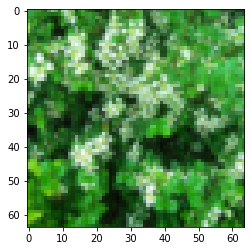

In [108]:
# Example of a picture that was wrongly classified.

print("*************test_set_x_flatten************")
#print(test_set_x_flatten[0])

print(test_set_x_orig[0].shape)

len = test_set_x_orig[0].shape[0] * test_set_x_orig[0].shape[1] * test_set_x_orig[0].shape[2]
print(len)
ratio = test_set_x_flatten[0][1]/test_set_x[0][1]
num_px = test_set_x_orig.shape[1]
index = 22
t1 = test_set_x_flatten.reshape(50,64,64,3)
plt.imshow(t1[index])

print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[test_set_y[0,index]].decode("utf-8") +  "\" picture.")

#print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[d["Y_prediction_test"][0,index]].decode("utf-8") +  "\" picture.")